<a href="https://colab.research.google.com/github/rabnawaz172/Voice_pathology_2/blob/main/voice_deep_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle

# Assuming the Google Drive dataset folder is loaded to a local directory using Google Colab
# Mount Google Drive first to access the files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Processing 111 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Train
Processing 117 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Train
Processing 47 files in class 'Normal' from /content/drive/MyDrive/Voice_2/Test_2


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol' from /content/drive/MyDrive/Voice_2/Test_2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4779 - loss: 14.3005 - val_accuracy: 0.6087 - val_loss: 2.2890
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.4771 - loss: 2.6659 - val_accuracy: 0.3913 - val_loss: 0.7249
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5253 - loss: 0.6966 - val_accuracy: 0.6739 - val_loss: 0.6441
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5079 - loss: 0.6792 - val_accuracy: 0.6739 - val_loss: 0.6505
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6291 - loss: 0.6678 - val_accuracy: 0.7174 - val_loss: 0.6265
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7043 - loss: 0.6302 - val_accuracy: 0.7391 - val_loss: 0.5902
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6613 - loss: 0.6504 - val_accuracy: 0.7826 - val_loss: 0.5776
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6650 - loss: 0.6037 - val_accuracy: 0.7174 - val_lo

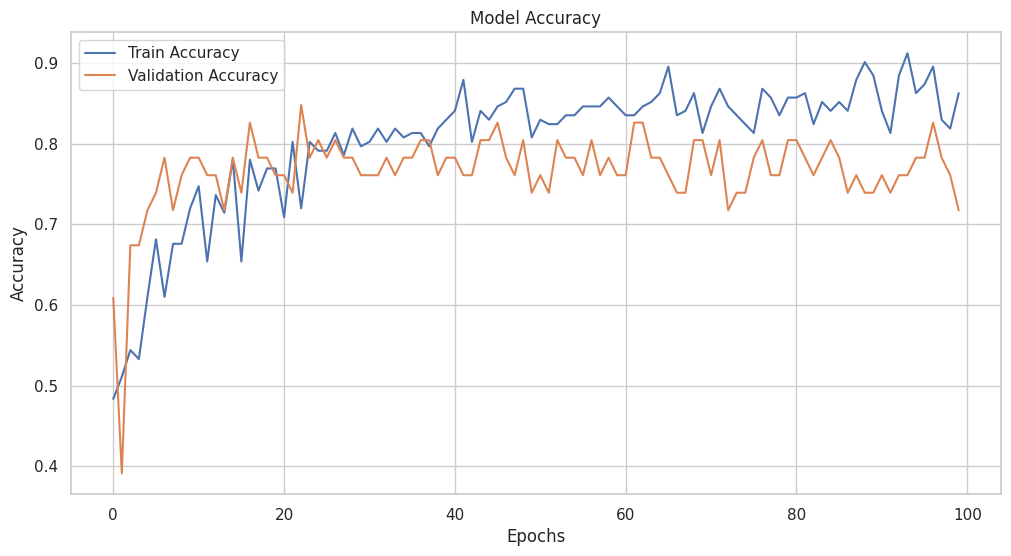

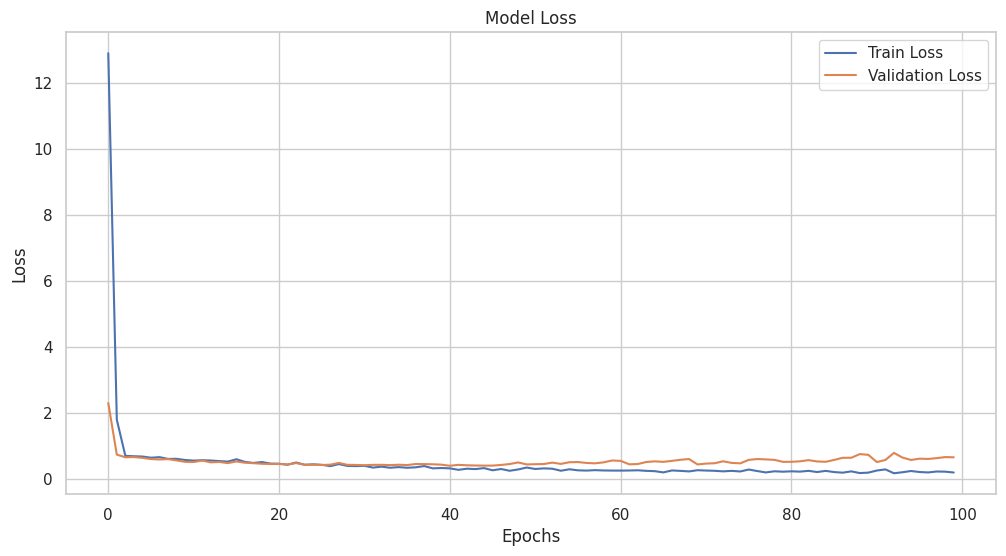

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style with grid
sns.set(style="whitegrid")

# Base paths
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Separate test data

# Audio class labels
classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Fixed audio length and Mel-spectrogram parameters
MAX_AUDIO_LENGTH = 16000  # 1 second at 16kHz
N_MELS = 64
TIME_STEPS = 32  # Desired time steps for model input

# Function to extract and process Mel-spectrogram
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH, time_steps=TIME_STEPS):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Pad or truncate audio to MAX_AUDIO_LENGTH
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure time_steps = 32 by padding or truncating
        t = mel_spec_db.shape[1]
        if t < time_steps:
            pad_width = time_steps - t
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif t > time_steps:
            mel_spec_db = mel_spec_db[:, :time_steps]

        # Expand to 3 channels (RGB-like)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

        return mel_spec_db_rgb

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, time_steps, 3))  # Return zero vector in case of error

# Function to load all data from a base path
def load_data(base_path, classes, labels):
    features = []
    targets = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}' from {base_path}")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
    return np.array(features), np.array(targets)

# Load training data (used for train + validation)
X_train_val, y_train_val = load_data(train_path, classes, labels)

# Load test data (unseen, used only for final evaluation)
X_test, y_test = load_data(test_path, classes, labels)

# Split training data into train and validation (80% train, 20% val)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Build the CNN model
model_hyb = models.Sequential([
    layers.InputLayer(input_shape=(N_MELS, TIME_STEPS, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_hyb.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_hyb = model_hyb.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate on validation data
Y_val_pred = (model_hyb.predict(X_val) > 0.5).astype(int)

val_accuracy = accuracy_score(Y_val, Y_val_pred)
val_precision = precision_score(Y_val, Y_val_pred)
val_recall = recall_score(Y_val, Y_val_pred)
val_f1 = f1_score(Y_val, Y_val_pred)

print(f"Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Evaluate on test data
Y_test_pred = (model_hyb.predict(X_test) > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, Y_test_pred)
test_precision = precision_score(y_test, Y_test_pred)
test_recall = recall_score(y_test, Y_test_pred)
test_f1 = f1_score(y_test, Y_test_pred)



# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['accuracy'], label='Train Accuracy')
plt.plot(history_hyb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_hyb.history['loss'], label='Train Loss')
plt.plot(history_hyb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in class 'Pathol'
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5318 - loss: 2.2586 - val_accuracy: 0.7188 - val_loss: 0.6471
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 788ms/step - accuracy: 0.5561 - loss: 1.9787 - val_accuracy: 0.6458 - val_loss: 0.5577
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 785ms/step - accuracy: 0.6039 - loss: 1.3416 - val_accuracy: 0.7292 - val_loss: 0.4551
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 830ms/step - accuracy: 0.6825 - loss: 0.9229 - val_accuracy: 0.7604 - val_loss: 0.4460
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6127 - loss: 0.9235 - val_accuracy: 0.8229 - val_loss: 0.4205
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 890ms/step - accuracy: 0.7110 - loss: 0.7862 - val_accuracy: 0.8021 - val_loss: 0.4121
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 892ms/step - accuracy: 0.6229 - loss: 0.9588 - val_accuracy: 0.8333 - val_loss: 0.4238
Epoch 8/100
8/8 ━━━━━━━

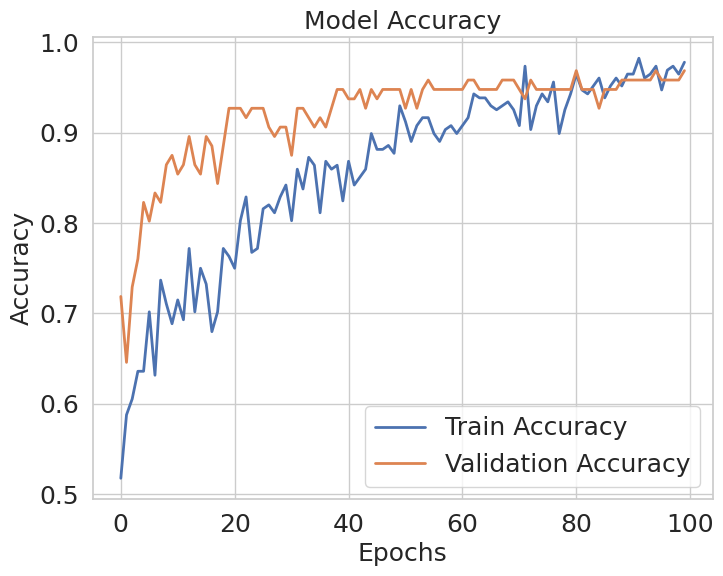

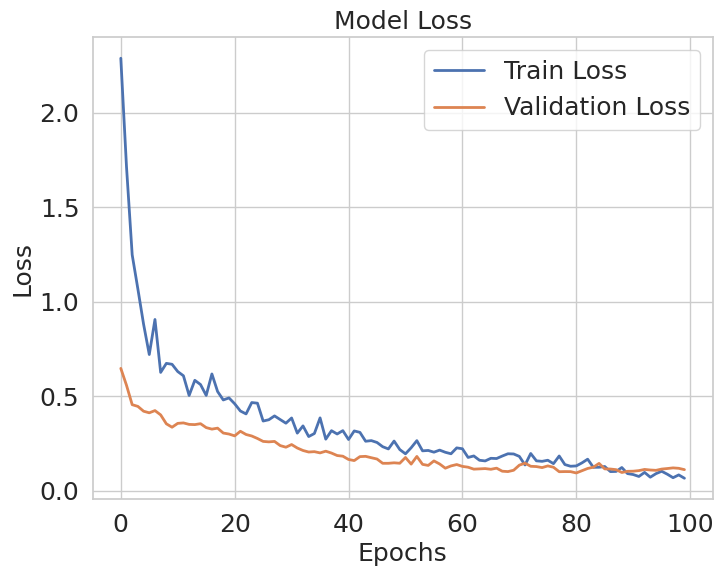

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Set seaborn style with grid
sns.set(style="whitegrid")

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_2'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
    return np.array(features), np.array(target)

# Load training and validation data
X_train, Y_train = load_data(train_path, classes, labels)
X_val, Y_val = load_data(test_path, classes, labels)

# Build the VGGish model for transfer learning
# Load VGG16 as base model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model_trans = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_trans.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_trans = model_trans.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,  # Adjust epochs as needed
    batch_size=32,  # Adjust batch size as needed
    verbose=1
)

# Evaluate the model
Y_val_pred_trans = (model_trans.predict(X_val) > 0.5).astype(int)

accuracy = accuracy_score(Y_val, Y_val_pred_trans)
precision = precision_score(Y_val, Y_val_pred_trans)
recall = recall_score(Y_val, Y_val_pred_trans)
f1 = f1_score(Y_val, Y_val_pred_trans)

print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Plot training loss history
plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()


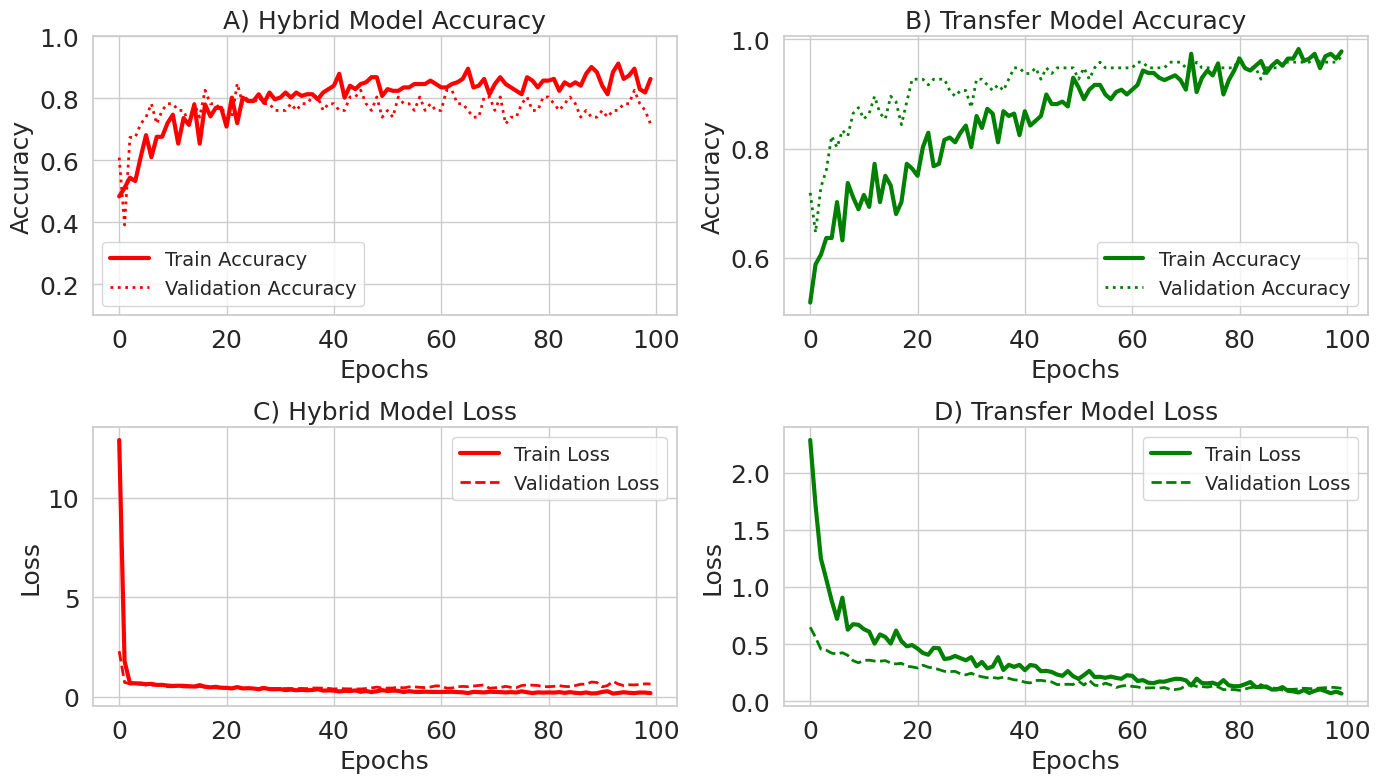

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ----------------------------
# Subplot A: Hybrid Model - Accuracy
# ----------------------------
axes[0, 0].plot(history_hyb.history['accuracy'], label='Train Accuracy', linewidth=3, color='red')
axes[0, 0].plot(history_hyb.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='red')
axes[0, 0].set_title('A) Hybrid Model Accuracy', fontsize=18)
axes[0, 0].set_xlabel('Epochs', fontsize=18)
axes[0, 0].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)  # Focus on 90% to 100% range
axes[0, 0].tick_params(axis='both', which='major', labelsize=18)
axes[0, 0].legend(fontsize=14)
axes[0, 0].grid(True)

# ----------------------------
# Subplot B: Transfer Model - Accuracy
# ----------------------------
axes[0, 1].plot(history_trans.history['accuracy'], label='Train Accuracy', linewidth=3, color='green')
axes[0, 1].plot(history_trans.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='dotted', color='green')
axes[0, 1].set_title('B) Transfer Model Accuracy', fontsize=18)
axes[0, 1].set_xlabel('Epochs', fontsize=18)
axes[0, 1].set_ylabel('Accuracy', fontsize=18)
axes[0, 0].set_ylim(0.1, 1.0)
axes[0, 1].tick_params(axis='both', which='major', labelsize=18)
axes[0, 1].legend(fontsize=14)
axes[0, 1].grid(True)

# ----------------------------
# Subplot C: Hybrid Model - Loss
# ----------------------------
axes[1, 0].plot(history_hyb.history['loss'], label='Train Loss', linewidth=3, color='red')
axes[1, 0].plot(history_hyb.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='red')
axes[1, 0].set_title('C) Hybrid Model Loss', fontsize=18)
axes[1, 0].set_xlabel('Epochs', fontsize=18)
axes[1, 0].set_ylabel('Loss', fontsize=18)


axes[1, 0].tick_params(axis='both', which='major', labelsize=18)
axes[1, 0].legend(fontsize=14)
axes[1, 0].grid(True)

# ----------------------------
# Subplot D: Transfer Model - Loss
# ----------------------------
axes[1, 1].plot(history_trans.history['loss'], label='Train Loss', linewidth=3, color='green')
axes[1, 1].plot(history_trans.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='dashed', color='green')
axes[1, 1].set_title('D) Transfer Model Loss', fontsize=18)
axes[1, 1].set_xlabel('Epochs', fontsize=18)
axes[1, 1].set_ylabel('Loss', fontsize=18)

axes[1, 1].tick_params(axis='both', which='major', labelsize=18)
axes[1, 1].legend(fontsize=14)
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()



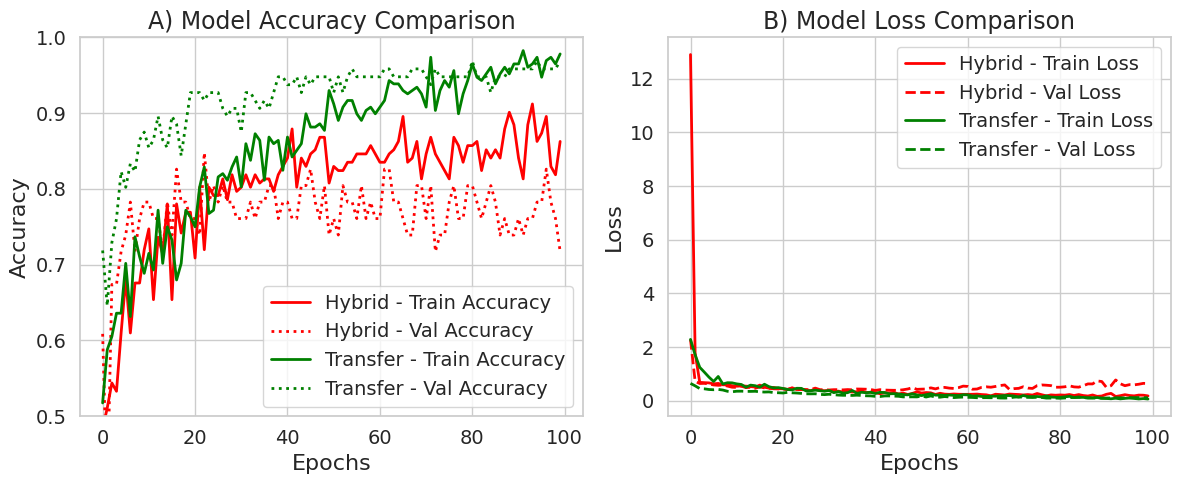

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files # Import files module
from google.colab import files
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Wider figure for side-by-side layout

# ----------------------------
# Subplot 0: Accuracy Comparison (Left)
# ----------------------------
# Hybrid model accuracy
axes[0].plot(history_hyb.history['accuracy'], label='Hybrid - Train Accuracy', linewidth=2, color='red')
axes[0].plot(history_hyb.history['val_accuracy'], label='Hybrid - Val Accuracy', linewidth=2, linestyle='dotted', color='red')

# Transfer learning model accuracy
axes[0].plot(history_trans.history['accuracy'], label='Transfer - Train Accuracy', linewidth=2, color='green')
axes[0].plot(history_trans.history['val_accuracy'], label='Transfer - Val Accuracy', linewidth=2, linestyle='dotted', color='green')

axes[0].set_title('A) Model Accuracy Comparison', fontsize=17)  # Added "A)"
axes[0].set_xlabel('Epochs', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=16)
axes[0].set_ylim(0.5, 1.0)  # Focus on relevant range
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=14)
axes[0].grid(True)

# ----------------------------
# Subplot 1: Loss Comparison (Right)
# ----------------------------
# Hybrid model loss
axes[1].plot(history_hyb.history['loss'], label='Hybrid - Train Loss', linewidth=2, color='red')
axes[1].plot(history_hyb.history['val_loss'], label='Hybrid - Val Loss', linewidth=2, linestyle='dashed', color='red')

# Transfer learning model loss
axes[1].plot(history_trans.history['loss'], label='Transfer - Train Loss', linewidth=2, color='green')
axes[1].plot(history_trans.history['val_loss'], label='Transfer - Val Loss', linewidth=2, linestyle='dashed', color='green')

axes[1].set_title('B) Model Loss Comparison', fontsize=17)  # Added "B)"
axes[1].set_xlabel('Epochs', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(fontsize=14)
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
# Save the figure to disk at 600 DPI
plt.savefig('train_valid_1.png', dpi=600, bbox_inches='tight')
# Show the combined figure
plt.show()


# Download the saved image
files.download('train_valid_1.png')


In [ ]:

model_hyb.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,631,429 (6.22 MB)

 Trainable params: 543,809 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,087,620 (4.15 MB)

In [ ]:

model_hyb.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,631,429 (6.22 MB)

 Trainable params: 543,809 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,087,620 (4.15 MB)

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Set seaborn style with grid
sns.set(style="whitegrid")

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_4'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
    return np.array(features), np.array(target)

# Load training and validation data
X_train, Y_train = load_data(train_path, classes, labels)
X_val, Y_val = load_data(test_path, classes, labels)


Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'
Processing 49 files in class 'Pathol'


In [ ]:
# Predict on validation set for both models (if not already done)
print("Predicting on validation set...")

Y_val_pred_prob_1 = model_hyb.predict(X_val)  # Hybrid model
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()

Y_val_pred_prob_2 = model_trans.predict(X_val)  # Transfer Learning model
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()

Predicting on validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step


Processing 47 files in class 'Normal'
Processing 49 files in class 'Pathol'
Test data shape: (96, 64, 32, 3), Labels shape: (96,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step

Incorrectly predicted Pathol files:
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A1-1333D0FyWy-cyt-f-35-n-481117-kac-0-x.wav
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A12-f62007-nor-f-23-n-430200905-kaf-0-p.wav
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A1-621-nor-f-20-n-430200919-kaf-0-p.wav
Predicting on validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 907ms/step


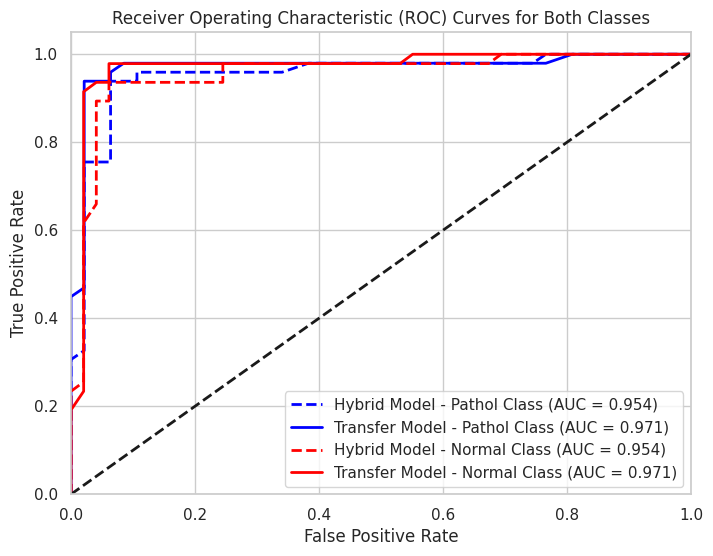

In [ ]:
# Predict on validation set for both models (if not already done)
def load_data(base_path, classes, labels):
    features = []
    targets = []
    file_paths = []  # To store the file paths

    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
            file_paths.append(file)  # Store the file path

    return np.array(features), np.array(targets), np.array(file_paths)
    print("Loading test dataset...")
X_test, Y_test, file_paths = load_data(test_path, classes, labels)
print(f"Test data shape: {X_test.shape}, Labels shape: {Y_test.shape}")
# Predict on the test set
Y_pred_prob = model_trans.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

# Identify incorrectly predicted Pathol samples
incorrect_pathol_files = []

for i in range(len(Y_test)):
    if Y_test[i] == 1 and Y_pred[i] == 0:  # True label is Pathol, predicted as Normal
        incorrect_pathol_files.append(file_paths[i])

# Print the list of incorrectly predicted Pathol files
print("\nIncorrectly predicted Pathol files:")
for file in incorrect_pathol_files:
    print(file)
print("Predicting on validation set...")

Y_val_pred_prob_1 = model_hyb.predict(X_val)  # Hybrid model
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()

Y_val_pred_prob_2 = model_trans.predict(X_val)  # Transfer Learning model
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for model_1 (assuming sigmoid output)
fpr_1, tpr_1, _ = roc_curve(Y_val, Y_val_pred_prob_1)  # Use predicted probabilities from model_1
roc_auc_1 = roc_auc_score(Y_val, Y_val_pred_prob_1)

# Calculate ROC curve and AUC for model_2 (assuming sigmoid output)
fpr_2, tpr_2, _ = roc_curve(Y_val, Y_val_pred_prob_2)  # Use predicted probabilities from model_2
roc_auc_2 = roc_auc_score(Y_val, Y_val_pred_prob_2)

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming Y_val contains binary labels: 0 = Normal, 1 = Pathol
# Predicted probabilities from models (already computed)
# Y_val_pred_prob_1 = model_hyb.predict(X_val)
# Y_val_pred_prob_2 = model_trans.predict(X_val)

# Invert probabilities to get predictions for the other class (Normal = 0 -> use 1 - probabilities)
Y_val_normal = 1 - Y_val  # True labels for Normal class
Y_val_pred_prob_1_normal = 1 - Y_val_pred_prob_1  # Hybrid model predictions for Normal
Y_val_pred_prob_2_normal = 1 - Y_val_pred_prob_2  # Transfer model predictions for Normal

# Compute ROC for Pathol class (original labels)
fpr_pathol_1, tpr_pathol_1, _ = roc_curve(Y_val, Y_val_pred_prob_1)
roc_auc_pathol_1 = roc_auc_score(Y_val, Y_val_pred_prob_1)

fpr_pathol_2, tpr_pathol_2, _ = roc_curve(Y_val, Y_val_pred_prob_2)
roc_auc_pathol_2 = roc_auc_score(Y_val, Y_val_pred_prob_2)

# Compute ROC for Normal class (inverted labels)
fpr_normal_1, tpr_normal_1, _ = roc_curve(Y_val_normal, Y_val_pred_prob_1_normal)
roc_auc_normal_1 = roc_auc_score(Y_val_normal, Y_val_pred_prob_1_normal)

fpr_normal_2, tpr_normal_2, _ = roc_curve(Y_val_normal, Y_val_pred_prob_2_normal)
roc_auc_normal_2 = roc_auc_score(Y_val_normal, Y_val_pred_prob_2_normal)

# Plotting
plt.figure(figsize=(8, 6))

# ROC for Pathol class
plt.plot(fpr_pathol_1, tpr_pathol_1,
         label=f'Hybrid Model - Pathol Class (AUC = {roc_auc_pathol_1:.3f})',
         linestyle='--', color='blue', linewidth=2)
plt.plot(fpr_pathol_2, tpr_pathol_2,
         label=f'Transfer Model - Pathol Class (AUC = {roc_auc_pathol_2:.3f})',
         linestyle='-', color='blue', linewidth=2)

# ROC for Normal class
plt.plot(fpr_normal_1, tpr_normal_1,
         label=f'Hybrid Model - Normal Class (AUC = {roc_auc_normal_1:.3f})',
         linestyle='--', color='red', linewidth=2)
plt.plot(fpr_normal_2, tpr_normal_2,
         label=f'Transfer Model - Normal Class (AUC = {roc_auc_normal_2:.3f})',
         linestyle='-', color='red', linewidth=2)

# Random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Both Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Processing 47 files in class 'Normal'
Processing 49 files in class 'Pathol'
Test data shape: (96, 64, 32, 3), Labels shape: (96,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step

Incorrectly predicted Pathol files:
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A1-1333D0FyWy-cyt-f-35-n-481117-kac-0-x.wav
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A12-f62007-nor-f-23-n-430200905-kaf-0-p.wav
/content/drive/MyDrive/Voice_2/Test_4/Pathol/A1-621-nor-f-20-n-430200919-kaf-0-p.wav
Predicting on validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step


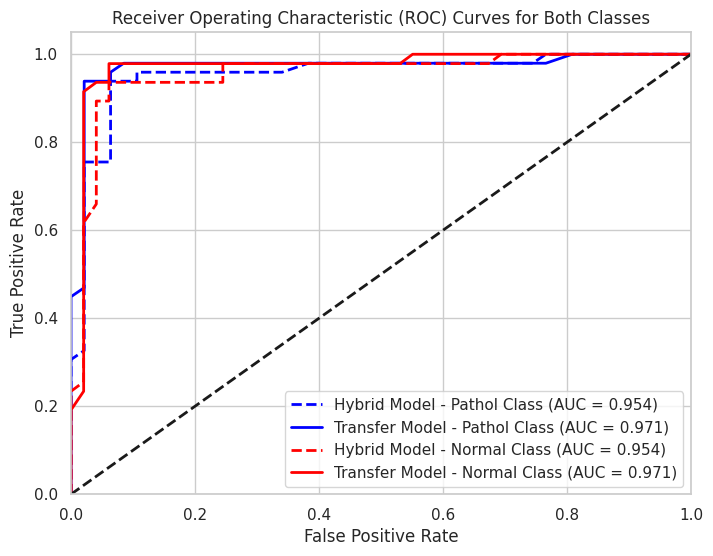

In [ ]:
# Predict on validation set for both models (if not already done)
def load_data(base_path, classes, labels):
    features = []
    targets = []
    file_paths = []  # To store the file paths

    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(labels[class_name])
            file_paths.append(file)  # Store the file path

    return np.array(features), np.array(targets), np.array(file_paths)
    print("Loading test dataset...")
X_test, Y_test, file_paths = load_data(test_path, classes, labels)
print(f"Test data shape: {X_test.shape}, Labels shape: {Y_test.shape}")
# Predict on the test set
Y_pred_prob = model_trans.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

# Identify incorrectly predicted Pathol samples
incorrect_pathol_files = []

for i in range(len(Y_test)):
    if Y_test[i] == 1 and Y_pred[i] == 0:  # True label is Pathol, predicted as Normal
        incorrect_pathol_files.append(file_paths[i])

# Print the list of incorrectly predicted Pathol files
print("\nIncorrectly predicted Pathol files:")
for file in incorrect_pathol_files:
    print(file)
print("Predicting on validation set...")

Y_val_pred_prob_1 = model_hyb.predict(X_val)  # Hybrid model
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()

Y_val_pred_prob_2 = model_trans.predict(X_val)  # Transfer Learning model
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for model_1 (assuming sigmoid output)
fpr_1, tpr_1, _ = roc_curve(Y_val, Y_val_pred_prob_1)  # Use predicted probabilities from model_1
roc_auc_1 = roc_auc_score(Y_val, Y_val_pred_prob_1)

# Calculate ROC curve and AUC for model_2 (assuming sigmoid output)
fpr_2, tpr_2, _ = roc_curve(Y_val, Y_val_pred_prob_2)  # Use predicted probabilities from model_2
roc_auc_2 = roc_auc_score(Y_val, Y_val_pred_prob_2)

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming Y_val contains binary labels: 0 = Normal, 1 = Pathol
# Predicted probabilities from models (already computed)
# Y_val_pred_prob_1 = model_hyb.predict(X_val)
# Y_val_pred_prob_2 = model_trans.predict(X_val)

# Invert probabilities to get predictions for the other class (Normal = 0 -> use 1 - probabilities)
Y_val_normal = 1 - Y_val  # True labels for Normal class
Y_val_pred_prob_1_normal = 1 - Y_val_pred_prob_1  # Hybrid model predictions for Normal
Y_val_pred_prob_2_normal = 1 - Y_val_pred_prob_2  # Transfer model predictions for Normal

# Compute ROC for Pathol class (original labels)
fpr_pathol_1, tpr_pathol_1, _ = roc_curve(Y_val, Y_val_pred_prob_1)
roc_auc_pathol_1 = roc_auc_score(Y_val, Y_val_pred_prob_1)

fpr_pathol_2, tpr_pathol_2, _ = roc_curve(Y_val, Y_val_pred_prob_2)
roc_auc_pathol_2 = roc_auc_score(Y_val, Y_val_pred_prob_2)

# Compute ROC for Normal class (inverted labels)
fpr_normal_1, tpr_normal_1, _ = roc_curve(Y_val_normal, Y_val_pred_prob_1_normal)
roc_auc_normal_1 = roc_auc_score(Y_val_normal, Y_val_pred_prob_1_normal)

fpr_normal_2, tpr_normal_2, _ = roc_curve(Y_val_normal, Y_val_pred_prob_2_normal)
roc_auc_normal_2 = roc_auc_score(Y_val_normal, Y_val_pred_prob_2_normal)

# Plotting
plt.figure(figsize=(8, 6))

# ROC for Pathol class
plt.plot(fpr_pathol_1, tpr_pathol_1,
         label=f'Hybrid Model - Pathol Class (AUC = {roc_auc_pathol_1:.3f})',
         linestyle='--', color='blue', linewidth=2)
plt.plot(fpr_pathol_2, tpr_pathol_2,
         label=f'Transfer Model - Pathol Class (AUC = {roc_auc_pathol_2:.3f})',
         linestyle='-', color='blue', linewidth=2)

# ROC for Normal class
plt.plot(fpr_normal_1, tpr_normal_1,
         label=f'Hybrid Model - Normal Class (AUC = {roc_auc_normal_1:.3f})',
         linestyle='--', color='red', linewidth=2)
plt.plot(fpr_normal_2, tpr_normal_2,
         label=f'Transfer Model - Normal Class (AUC = {roc_auc_normal_2:.3f})',
         linestyle='-', color='red', linewidth=2)

# Random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Both Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Processing 111 files in class 'Normal'
Processing 117 files in class 'Pathol'
Processing 47 files in class 'Normal'
Processing 49 files in class 'Pathol'
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step


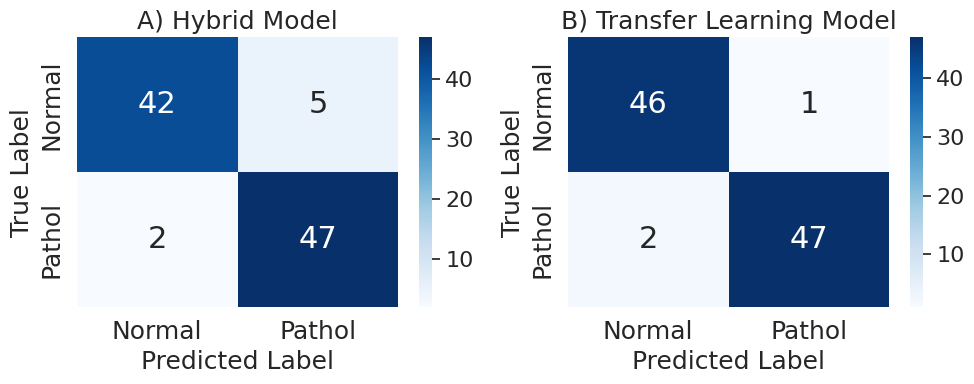

Model 1 Metrics:
Accuracy: 0.93
Precision: 0.90
Recall: 0.96
F1 Score: 0.93

Model 2 Metrics:
Accuracy: 0.97
Precision: 0.98
Recall: 0.96
F1 Score: 0.97

Files misclassified by both models:
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-42227-plp-m-66-n-571150-kac-2-p.wav
  True Label: Normal | Model 1 Prediction: Pathol | Model 2 Prediction: Pathol
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A12-f62007-nor-f-23-n-430200905-kaf-0-p.wav
  True Label: Pathol | Model 1 Prediction: Normal | Model 2 Prediction: Normal
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1-621-nor-f-20-n-430200919-kaf-0-p.wav
  True Label: Pathol | Model 1 Prediction: Normal | Model 2 Prediction: Normal


In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
import glob

# Set base paths for training and validation
train_path = '/content/drive/MyDrive/Voice_2/Train'  # Training data
test_path = '/content/drive/MyDrive/Voice_2/Test_4'  # Separate test data


classes = ['Normal', 'Pathol']
labels = {'Normal': 0, 'Pathol': 1}

# Define the maximum audio length and padding
MAX_AUDIO_LENGTH = 16000  # 1 second of audio at 16 kHz sampling rate

# Function to extract Mel-spectrogram from the audio
def extract_mel_spectrogram(file_path, max_len=MAX_AUDIO_LENGTH):
    try:
        # Load audio file with librosa (no resampling)
        y, sr = librosa.load(file_path, sr=None)
        # If the audio is shorter than max_len, pad it with zeros
        if len(y) < max_len:
            pad_width = max_len - len(y)
            y = np.pad(y, (0, pad_width), mode='constant')
        # If the audio is longer than max_len, truncate it
        elif len(y) > max_len:
            y = y[:max_len]

        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Reshape to match the input of the model (height, width, channels)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Shape (64, time, 1)

        # Replicate the single channel to simulate RGB channels (64, time, 3)
        mel_spec_db_rgb = np.repeat(mel_spec_db, 3, axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        mel_spec_db_rgb = np.zeros((64, 100, 3))  # Return a zero vector in case of error
    return mel_spec_db_rgb

def load_data(base_path, classes, labels):
    features = []
    target = []
    file_paths = []  # To store corresponding file paths
    for class_name in classes:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)

        print(f"Processing {len(file_list)} files in class '{class_name}'")

        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            target.append(labels[class_name])
            file_paths.append(file)  # Save the file path
    return np.array(features), np.array(target), file_paths

# Load training and validation data
X_train, Y_train, train_files = load_data(train_path, classes, labels)
X_val, Y_val, val_files = load_data(test_path, classes, labels)

# Predict on the validation set for model_1
Y_val_pred_prob_1 = model_hyb.predict(X_val)
Y_val_pred_1 = (Y_val_pred_prob_1 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_1
cm_1 = confusion_matrix(Y_val, Y_val_pred_1, labels=[0, 1])

# Predict on the validation set for model_2
Y_val_pred_prob_2 = model_trans.predict(X_val)
Y_val_pred_2 = (Y_val_pred_prob_2 > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix for model_2
cm_2 = confusion_matrix(Y_val, Y_val_pred_2, labels=[0, 1])

# Plot confusion matrices (same as before)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns_heatmap_1 = sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Normal', 'Pathol'],
                            yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[0])
axes[0].set_title('A) Hybrid Model', fontsize=18)
axes[0].set_xlabel('Predicted Label', fontsize=18)
axes[0].set_ylabel('True Label', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)
for text in axes[0].texts:
    text.set_fontsize(22)
cbar_1 = sns_heatmap_1.collections[0].colorbar
cbar_1.ax.tick_params(labelsize=16)

sns_heatmap_2 = sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Normal', 'Pathol'],
                            yticklabels=['Normal', 'Pathol'], cbar=True, ax=axes[1])
axes[1].set_title('B) Transfer Learning Model', fontsize=18)
axes[1].set_xlabel('Predicted Label', fontsize=18)
axes[1].set_ylabel('True Label', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
for text in axes[1].texts:
    text.set_fontsize(22)
cbar_2 = sns_heatmap_2.collections[0].colorbar
cbar_2.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()

# Print evaluation metrics for model_1
accuracy_1 = accuracy_score(Y_val, Y_val_pred_1)
precision_1 = precision_score(Y_val, Y_val_pred_1)
recall_1 = recall_score(Y_val, Y_val_pred_1)
f1_1 = f1_score(Y_val, Y_val_pred_1)

print("Model 1 Metrics:")
print(f"Accuracy: {accuracy_1:.2f}")
print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")

# Print evaluation metrics for model_2
accuracy_2 = accuracy_score(Y_val, Y_val_pred_2)
precision_2 = precision_score(Y_val, Y_val_pred_2)
recall_2 = recall_score(Y_val, Y_val_pred_2)
f1_2 = f1_score(Y_val, Y_val_pred_2)

print("\nModel 2 Metrics:")
print(f"Accuracy: {accuracy_2:.2f}")
print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"F1 Score: {f1_2:.2f}")

# Find files misclassified by both models
Y_val_true = np.array(Y_val).flatten()
Y_val_pred_1_flat = Y_val_pred_1
Y_val_pred_2_flat = Y_val_pred_2

misclassified_by_both = [
    i for i in range(len(Y_val_true))
    if Y_val_true[i] != Y_val_pred_1_flat[i] and Y_val_true[i] != Y_val_pred_2_flat[i]
]

# Print file names misclassified by both models
print("\nFiles misclassified by both models:")
for idx in misclassified_by_both:
    true_label = classes[Y_val_true[idx]]
    pred_label_1 = classes[Y_val_pred_1_flat[idx]]
    pred_label_2 = classes[Y_val_pred_2_flat[idx]]
    file_path = val_files[idx]
    print(f"File: {file_path}")
    print(f"  True Label: {true_label} | "
          f"Model 1 Prediction: {pred_label_1} | "
          f"Model 2 Prediction: {pred_label_2}")

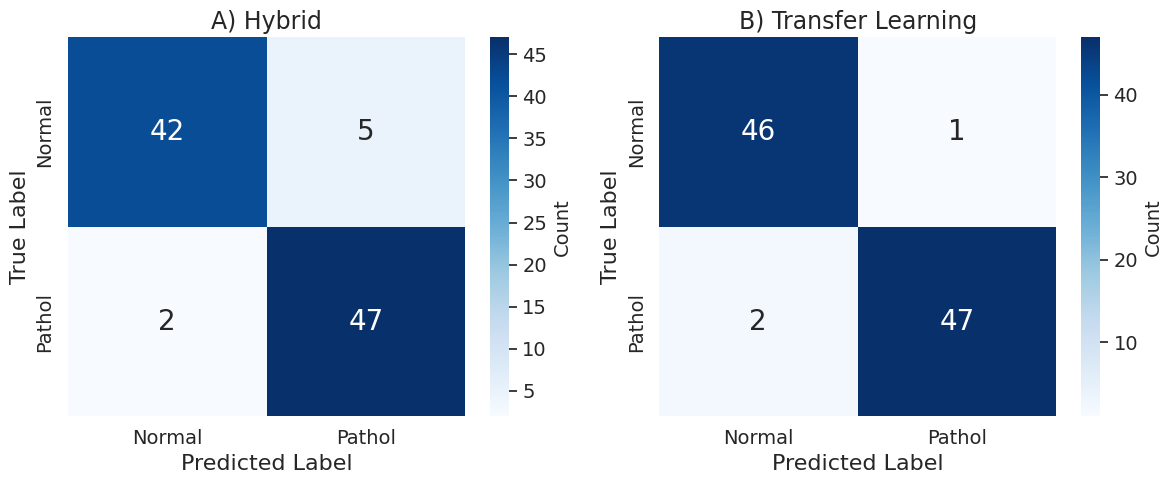

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Learning Models ---
# Assuming:
# cm_1 = confusion_matrix(Y_val, Y_val_pred_1)  --> Hybrid
# cm_2 = confusion_matrix(Y_val, Y_val_pred_2)  --> Transfer Learning

# Combine only deep learning confusion matrices
cms = [cm_1, cm_2]

titles = [
    'A) Hybrid',
    'B) Transfer Learning',
]

# Create a figure with 1x2 layout (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    sns.heatmap(cms[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pathol'],
                yticklabels=['Normal', 'Pathol'], cbar=True, ax=ax)

    ax.set_title(titles[i], fontsize=17)
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Increase annotation font size
    for text in ax.texts:
        text.set_fontsize(20)

    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Count', fontsize=14)

plt.tight_layout()
plt.savefig('cm_13.png', dpi=700, bbox_inches='tight', facecolor='white')
plt.show()


# Download the saved image
files.download('cm_13.png')

In [ ]:
from sklearn.metrics import classification_report

# Define model names for display
model_names = ['model_hybrid', 'model_trans']

# List of true labels and predictions
y_true = Y_val
preds_list = [Y_val_pred_1, Y_val_pred_2]

print("\nPer-Class Evaluation Metrics (Precision, Recall, F1-Score)")

for idx, preds in enumerate(preds_list):
    print(f"\n✅ {model_names[idx]}:")
    report = classification_report(
        y_true,
        preds,
        target_names=classes,
        digits=4
    )
    print(report)


Per-Class Evaluation Metrics (Precision, Recall, F1-Score)

✅ model_hybrid:
              precision    recall  f1-score   support

      Normal     0.9545    0.8936    0.9231        47
      Pathol     0.9038    0.9592    0.9307        49

    accuracy                         0.9271        96
   macro avg     0.9292    0.9264    0.9269        96
weighted avg     0.9287    0.9271    0.9270        96


✅ model_trans:
              precision    recall  f1-score   support

      Normal     0.9583    0.9787    0.9684        47
      Pathol     0.9792    0.9592    0.9691        49

    accuracy                         0.9688        96
   macro avg     0.9688    0.9690    0.9687        96
weighted avg     0.9690    0.9688    0.9688        96



In [ ]:

# Assuming:
# Y_val_true: true labels (ground truth)
# Y_val_pred_1_flat: predictions from Model 1
# val_files: list of file paths in validation set (in same order as predictions)

# Get indices where true label is 'Normal' (0)
normal_indices = np.where(Y_val_true == 0)[0]

# Get indices where true label is 'Pathol' (1)
pathol_indices = np.where(Y_val_true == 1)[0]

# Find false positives (Normal -> Pathol)
false_positives = [
    i for i in normal_indices
    if Y_val_pred_1_flat[i] == 1
]

# Find false negatives (Pathol -> Normal)
false_negatives = [
    i for i in pathol_indices
    if Y_val_pred_1_flat[i] == 0
]

# Print results
print("\n🔴 False Positives (Normal misclassified as Pathol):")
for idx in false_positives:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Normal | Prediction: Pathol\n")

print("\n🔵 False Negatives (Pathol misclassified as Normal):")
for idx in false_negatives:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Pathol | Prediction: Normal\n")


🔴 False Positives (Normal misclassified as Pathol):
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-62007-nor-f-20-n-430201569-kaf-0-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-4333D1FyWy-plp-m-51-n-70083191-rm-3-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-42227-plp-m-66-n-571150-kac-2-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1my-62007-nor-f-20-n-430201569-kaf-0-p.wav
  True Label: Normal | Prediction: Pathol

File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1my-4333D1FyWy-plp-m-51-n-70083191-rm-3-p.wav
  True Label: Normal | Prediction: Pathol


🔵 False Negatives (Pathol misclassified as Normal):
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A12-f62007-nor-f-23-n-430200905-kaf-0-p.wav
  True Label: Pathol | Prediction: Normal

File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1-621-nor-f-20-n-

In [ ]:
# Assuming:
# Y_val_true: true labels (ground truth)
# Y_val_pred_2_flat: predictions from Model 2
# val_files: list of file paths in validation set (in same order as predictions)

# Get indices where true label is 'Normal' (0)
normal_indices = np.where(Y_val_true == 0)[0]

# Get indices where true label is 'Pathol' (1)
pathol_indices = np.where(Y_val_true == 1)[0]

# Find false positives (Normal -> Pathol) for Model 2
false_positives_model2 = [
    i for i in normal_indices
    if Y_val_pred_2_flat[i] == 1
]

# Find false negatives (Pathol -> Normal) for Model 2
false_negatives_model2 = [
    i for i in pathol_indices
    if Y_val_pred_2_flat[i] == 0
]

# Print results for Model 2
print("\nFalse Positives (Normal misclassified as Pathol) - Model 2:")
for idx in false_positives_model2:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Normal | Prediction: Pathol\n")

print("\nFalse Negatives (Pathol misclassified as Normal) - Model 2:")
for idx in false_negatives_model2:
    print(f"File: {val_files[idx]}")
    print(f"  True Label: Pathol | Prediction: Normal\n")


False Positives (Normal misclassified as Pathol) - Model 2:
File: /content/drive/MyDrive/Voice_2/Test_4/Normal/A1-42227-plp-m-66-n-571150-kac-2-p.wav
  True Label: Normal | Prediction: Pathol


False Negatives (Pathol misclassified as Normal) - Model 2:
File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A12-f62007-nor-f-23-n-430200905-kaf-0-p.wav
  True Label: Pathol | Prediction: Normal

File: /content/drive/MyDrive/Voice_2/Test_4/Pathol/A1-621-nor-f-20-n-430200919-kaf-0-p.wav
  True Label: Pathol | Prediction: Normal



In [ ]:
import os
import numpy as np
import librosa
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import files
from tabulate import tabulate

sns.set(style="whitegrid")

# Base paths
train_data_path = '/content/drive/MyDrive/Voice_2/Train'
test_data_path = '/content/drive/MyDrive/Voice_2/Test_2'

# Audio class labels
class_labels = ['Normal', 'Pathol']
label_to_index = {'Normal': 0, 'Pathol': 1}

# Fixed audio length and Mel-spectrogram parameters
MAX_AUDIO_LENGTH = 16000
N_MELS = 64
TIME_STEPS = 32

# Function to extract and process Mel-spectrogram
def extract_mel_spectrogram(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) < MAX_AUDIO_LENGTH:
            y = np.pad(y, (0, MAX_AUDIO_LENGTH - len(y)), mode='constant')
        else:
            y = y[:MAX_AUDIO_LENGTH]

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        t = mel_spec_db.shape[1]
        if t < TIME_STEPS:
            pad_width = TIME_STEPS - t
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif t > TIME_STEPS:
            mel_spec_db = mel_spec_db[:, :TIME_STEPS]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, TIME_STEPS))

# Load data
def load_data(base_path):
    features, targets = [], []
    for class_name in class_labels:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in '{class_name}'")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(label_to_index[class_name])
    return np.array(features), np.array(targets)

# Flatten spectrograms
def flatten_data(X):
    return X.reshape(len(X), -1)

# Load datasets
X_train_val_raw, y_train_val_raw = load_data(train_data_path)
X_test_raw, y_test_raw = load_data(test_data_path)

# Split into train and validation
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_val_raw, y_train_val_raw, test_size=0.2, random_state=42
)

# Flatten for ML models
X_train_flat = flatten_data(X_train_raw)
X_val_flat = flatten_data(X_val_raw)
X_test_flat = flatten_data(X_test_raw)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Save scaled validation and test sets for later use
X_val_scaled_svm = X_val_scaled
X_test_scaled_svm = X_test_scaled
y_val_svm = y_val
y_test_svm = y_test_raw

# Define models
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    # Predict
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Metrics
    val_acc = accuracy_score(y_val, y_val_pred)
    val_pre = precision_score(y_val, y_val_pred)
    val_rec = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    test_acc = accuracy_score(y_test_raw, y_test_pred)
    test_pre = precision_score(y_test_raw, y_test_pred)
    test_rec = recall_score(y_test_raw, y_test_pred)
    test_f1 = f1_score(y_test_raw, y_test_pred)

    results.append({
        "Model": name,
        "Val Accuracy": val_acc,
        "Test Accuracy": test_acc,
        "Val F1": val_f1,
        "Test F1": test_f1
    })

    print(f"{name} - Val Acc: {val_acc:.4f}, Test F1: {test_f1:.4f}")

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Print Tabulated Results
print("\n📊 Performance Comparison:")
print(tabulate(df_results, headers="keys", tablefmt="grid", floatfmt=".4f"))

# Confusion Matrix Plot
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test_raw, y_pred)



# Save the SVM model for later use
svm_model = models["SVM"]

# Predict probabilities for SVM on validation set
y_val_pred_prob_svm = svm_model.predict_proba(X_val_scaled_svm)[:, 1]  # Probability of class 1 (Pathol)

# Invert probabilities for Normal class
y_val_pred_prob_svm_normal = 1 - y_val_pred_prob_svm

# True binary labels for Normal class
y_val_normal = 1 - y_val_svm

# Compute ROC for SVM
fpr_pathol_svm, tpr_pathol_svm, _ = roc_curve(y_val_svm, y_val_pred_prob_svm)
roc_auc_pathol_svm = roc_auc_score(y_val_svm, y_val_pred_prob_svm)

fpr_normal_svm, tpr_normal_svm, _ = roc_curve(y_val_normal, y_val_pred_prob_svm_normal)
roc_auc_normal_svm = roc_auc_score(y_val_normal, y_val_pred_prob_svm_normal)



# Download the saved image

Processing 111 files in 'Normal'
Processing 117 files in 'Pathol'
Processing 47 files in 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in 'Pathol'

Training SVM...
SVM - Val Acc: 0.8043, Test F1: 0.9307

📊 Performance Comparison:
+----+---------+----------------+-----------------+----------+-----------+
|    | Model   |   Val Accuracy |   Test Accuracy |   Val F1 |   Test F1 |
+====+=========+================+=================+==========+===========+
|  0 | SVM     |         0.8043 |          0.9271 |   0.8475 |    0.9307 |
+----+---------+----------------+-----------------+----------+-----------+


Processing 47 files in 'Normal'


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 49 files in 'Pathol'

📊 Evaluation on Test_6:
Accuracy: 0.8646, Precision: 0.8462, Recall: 0.8980, F1-Score: 0.8713
AUC-ROC Pathol Class: 0.9195, AUC-ROC Normal Class: 0.9195


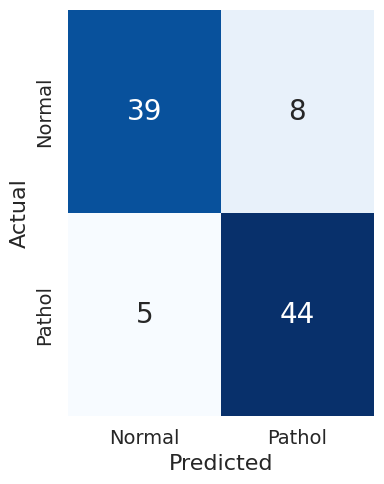

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Update the test path to Test_6
test_data_path = '/content/drive/MyDrive/Voice_2/Test_6'  # Changed from Test_2 to Test_6

# Function definitions remain unchanged
def extract_mel_spectrogram(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) < MAX_AUDIO_LENGTH:
            y = np.pad(y, (0, MAX_AUDIO_LENGTH - len(y)), mode='constant')
        else:
            y = y[:MAX_AUDIO_LENGTH]

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        t = mel_spec_db.shape[1]
        if t < TIME_STEPS:
            pad_width = TIME_STEPS - t
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif t > TIME_STEPS:
            mel_spec_db = mel_spec_db[:, :TIME_STEPS]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((N_MELS, TIME_STEPS))

def load_data(base_path):
    features, targets = [], []
    for class_name in class_labels:
        class_path = os.path.join(base_path, class_name, '*.wav')
        file_list = glob.glob(class_path)
        print(f"Processing {len(file_list)} files in '{class_name}'")
        for file in file_list:
            mel_spec = extract_mel_spectrogram(file)
            features.append(mel_spec)
            targets.append(label_to_index[class_name])
    return np.array(features), np.array(targets)

def flatten_data(X):
    return X.reshape(len(X), -1)

# Load Test_6 data
X_test_raw_new, y_test_new = load_data(test_data_path)

# Flatten and scale
X_test_flat_new = flatten_data(X_test_raw_new)
X_test_scaled_new = scaler.transform(X_test_flat_new)  # Use the same StandardScaler

# Predict with the pre-trained SVM model
y_test_pred_new = svm_model.predict(X_test_scaled_new)
y_test_prob_new = svm_model.predict_proba(X_test_scaled_new)[:, 1]  # Probabilities for Pathol class

# Invert labels for Normal class
y_test_normal_new = 1 - y_test_new
y_test_prob_normal_new = 1 - y_test_prob_new

# Compute metrics
acc = accuracy_score(y_test_new, y_test_pred_new)
pre = precision_score(y_test_new, y_test_pred_new)
rec = recall_score(y_test_new, y_test_pred_new)
f1 = f1_score(y_test_new, y_test_pred_new)

# ROC for both classes
fpr_pathol, tpr_pathol, _ = roc_curve(y_test_new, y_test_prob_new)
roc_auc_pathol = roc_auc_score(y_test_new, y_test_prob_new)

fpr_normal, tpr_normal, _ = roc_curve(y_test_normal_new, y_test_prob_normal_new)
roc_auc_normal = roc_auc_score(y_test_normal_new, y_test_prob_normal_new)

# Confusion Matrix
cm = confusion_matrix(y_test_new, y_test_pred_new)

# Display Results
print("\n📊 Evaluation on Test_6:")
print(f"Accuracy: {acc:.4f}, Precision: {pre:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
print(f"AUC-ROC Pathol Class: {roc_auc_pathol:.4f}, AUC-ROC Normal Class: {roc_auc_normal:.4f}")

# Confusion Matrix Plot
plt.figure(figsize=(4, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Pathol'],
                 yticklabels=['Normal', 'Pathol'])

plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Increase annotation font size inside heatmap
for text in ax.texts:
    text.set_fontsize(20)

plt.tight_layout()
plt.savefig('svm_cm_13.png', dpi=700, bbox_inches='tight', facecolor='white')
plt.show()
files.download('svm_cm_13.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

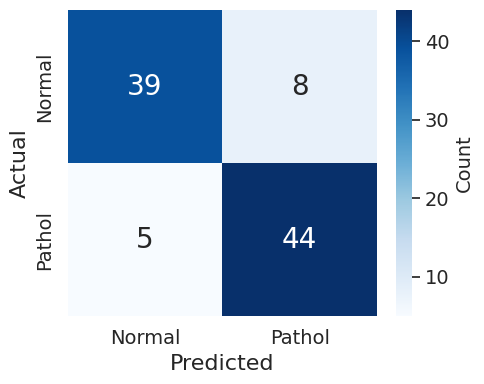

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cm is your confusion matrix
plt.figure(figsize=(5, 4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                 xticklabels=['Normal', 'Pathol'],
                 yticklabels=['Normal', 'Pathol'])

# Add colorbar with title and set font size for title and ticks
cbar = ax.collections[0].colorbar
cbar.set_label('Count', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Increase annotation font size inside heatmap
for text in ax.texts:
    text.set_fontsize(20)
plt.tight_layout()
plt.savefig('svm_cm.png', dpi=500, bbox_inches='tight', facecolor='white')


files.download('svm_cm.png')
plt.show()


In [ ]:
from sklearn.metrics import (
    classification_report,
    cohen_kappa_score,
    matthews_corrcoef,
    hamming_loss
)

# Print classification report
print("\n📄 Classification Report:")
print(classification_report(y_test_new, y_test_pred_new, target_names=['Normal', 'Pathol']))

# Additional metrics
kappa = cohen_kappa_score(y_test_new, y_test_pred_new)
mcc = matthews_corrcoef(y_test_new, y_test_pred_new)
hamming = hamming_loss(y_test_new, y_test_pred_new)

print(f"Cohen’s Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Hamming Loss: {hamming:.4f}")



📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.83      0.86        47
      Pathol       0.85      0.90      0.87        49

    accuracy                           0.86        96
   macro avg       0.87      0.86      0.86        96
weighted avg       0.87      0.86      0.86        96

Cohen’s Kappa: 0.7287
Matthews Correlation Coefficient (MCC): 0.7301
Hamming Loss: 0.1354


In [ ]:
# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)  # Make sure to train the model again if not already done

    # Predict
    y_train_pred = svm_model.predict(X_train_scaled)
    y_val_pred = svm_model.predict(X_val_scaled_svm)
    y_test_pred = svm_model.predict(X_test_scaled_svm)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val_svm, y_val_pred)
    test_acc = accuracy_score(y_test_svm, y_test_pred)

    val_pre = precision_score(y_val_svm, y_val_pred)
    val_rec = recall_score(y_val_svm, y_val_pred)
    val_f1 = f1_score(y_val_svm, y_val_pred)

    test_pre = precision_score(y_test_svm, y_test_pred)
    test_rec = recall_score(y_test_svm, y_test_pred)
    test_f1 = f1_score(y_test_svm, y_test_pred)

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Val Accuracy": val_acc,

    })

    print(f"{name} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test F1: {test_f1:.4f}")

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Print Tabulated Results
print("\n📊 Performance Comparison:")
print(tabulate(df_results, headers="keys", tablefmt="grid", floatfmt=".4f"))


Training SVM...
SVM - Train Acc: 0.9670, Val Acc: 0.8043, Test F1: 0.9307

📊 Performance Comparison:
+----+---------+------------------+----------------+
|    | Model   |   Train Accuracy |   Val Accuracy |
+====+=========+==================+================+
|  0 | SVM     |           0.9670 |         0.8043 |
+----+---------+------------------+----------------+


In [ ]:

from sklearn.metrics import classification_report

for name, model in models.items():
    y_test_pred = svm_model.predict(X_test_scaled)

    # Generate classification report
    print(f"\n📋 Classification Report - {name}")
    print(classification_report(y_test, y_test_pred, target_names=classes, digits=4))


📋 Classification Report - SVM
              precision    recall  f1-score   support

      Normal     0.9545    0.8936    0.9231        47
      Pathol     0.9038    0.9592    0.9307        49

    accuracy                         0.9271        96
   macro avg     0.9292    0.9264    0.9269        96
weighted avg     0.9287    0.9271    0.9270        96



In [ ]:
from sklearn.metrics import classification_report

# Define model names for display
model_names = ['model_hybrid', 'model_trans']

# List of true labels and predictions
y_true = Y_val
preds_list = [Y_val_pred_1, Y_val_pred_2]

print("\nPer-Class Evaluation Metrics (Precision, Recall, F1-Score)")

for idx, preds in enumerate(preds_list):
    print(f"\n✅ {model_names[idx]}:")
    report = classification_report(
        y_true,
        preds,
        target_names=classes,
        digits=4
    )
    print(report)


Per-Class Evaluation Metrics (Precision, Recall, F1-Score)

✅ model_hybrid:
              precision    recall  f1-score   support

      Normal     0.9545    0.8936    0.9231        47
      Pathol     0.9038    0.9592    0.9307        49

    accuracy                         0.9271        96
   macro avg     0.9292    0.9264    0.9269        96
weighted avg     0.9287    0.9271    0.9270        96


✅ model_trans:
              precision    recall  f1-score   support

      Normal     0.9583    0.9787    0.9684        47
      Pathol     0.9792    0.9592    0.9691        49

    accuracy                         0.9688        96
   macro avg     0.9688    0.9690    0.9687        96
weighted avg     0.9690    0.9688    0.9688        96



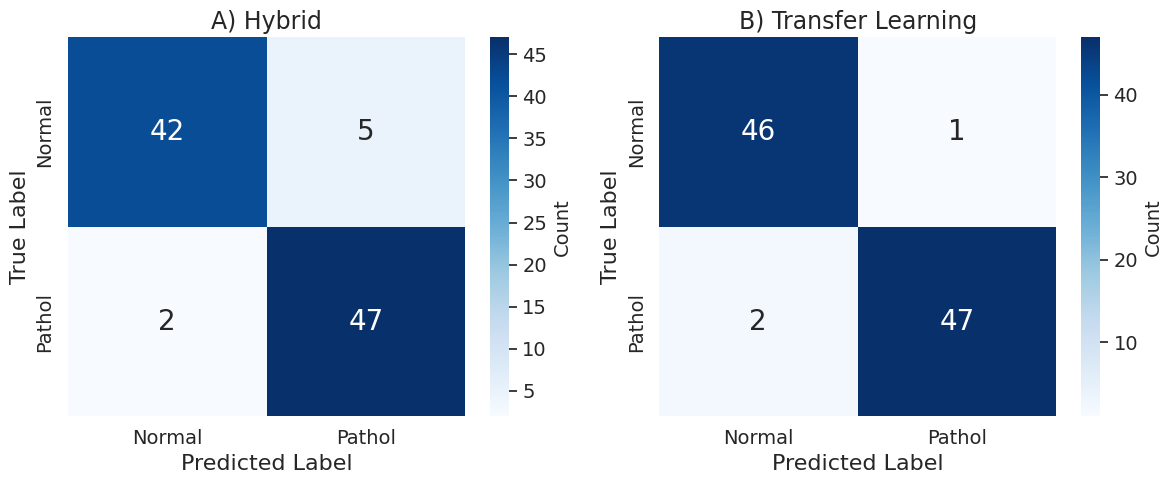

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Learning Models ---
# Assuming:
# cm_1 = confusion_matrix(Y_val, Y_val_pred_1)  --> Hybrid
# cm_2 = confusion_matrix(Y_val, Y_val_pred_2)  --> Transfer Learning

# Combine only deep learning confusion matrices
cms = [cm_1, cm_2]

titles = [
    'A) Hybrid',
    'B) Transfer Learning',
]

# Create a figure with 1x2 layout (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    sns.heatmap(cms[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pathol'],
                yticklabels=['Normal', 'Pathol'], cbar=True, ax=ax)

    ax.set_title(titles[i], fontsize=17)
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Increase annotation font size
    for text in ax.texts:
        text.set_fontsize(20)

    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Count', fontsize=14)

plt.tight_layout()
plt.savefig('cm_13.png', dpi=700, bbox_inches='tight', facecolor='white')
plt.show()


# Download the saved image
files.download('cm_13.png')

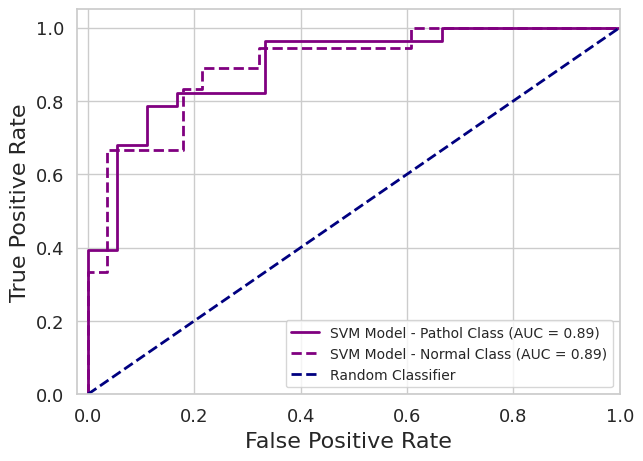

In [ ]:
# Plotting all models including SVM
plt.figure(figsize=(7, 5))

# ROC for Pathol class
plt.plot(fpr_pathol_svm, tpr_pathol_svm,
         label=f'SVM Model - Pathol Class (AUC = {roc_auc_pathol_svm:.2f})',
         linestyle='-', color='purple', linewidth=2)

# ROC for Normal class
plt.plot(fpr_normal_svm, tpr_normal_svm,
         label=f'SVM Model - Normal Class (AUC = {roc_auc_normal_svm:.2f})',
         linestyle='--', color='purple', linewidth=2)

# Random classifier line
plt.plot([0, 1], [0, 1],
         color='navy', linestyle='--', linewidth=2, label='Random Classifier')

# Formatting
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.savefig('roc_svm_only.png', dpi=600, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

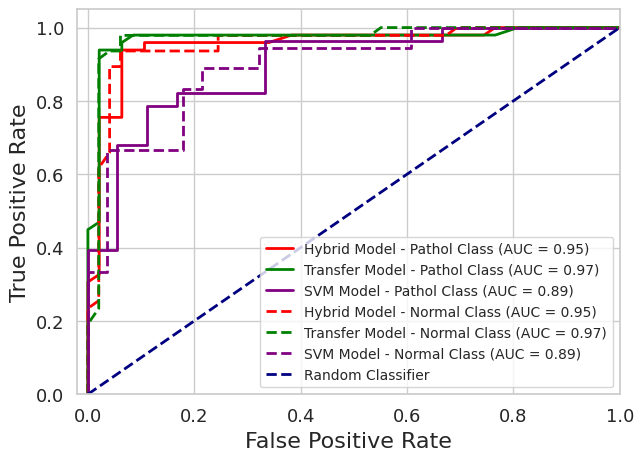

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Predict probabilities for SVM on validation set
y_val_pred_prob_svm = svm_model.predict_proba(X_val_scaled_svm)[:, 1]  # Probability of class 1 (Pathol)

# Invert probabilities for Normal class
y_val_pred_prob_svm_normal = 1 - y_val_pred_prob_svm

# True binary labels for Normal class
y_val_normal = 1 - y_val_svm

# Compute ROC for SVM
fpr_pathol_svm, tpr_pathol_svm, _ = roc_curve(y_val_svm, y_val_pred_prob_svm)
roc_auc_pathol_svm = roc_auc_score(y_val_svm, y_val_pred_prob_svm)

fpr_normal_svm, tpr_normal_svm, _ = roc_curve(y_val_normal, y_val_pred_prob_svm_normal)
roc_auc_normal_svm = roc_auc_score(y_val_normal, y_val_pred_prob_svm_normal)

# Plotting all models including SVM
# Plotting all models including SVM
plt.figure(figsize=(7, 5))

# ROC for Pathol class
plt.plot(fpr_pathol_1, tpr_pathol_1,
         label=f'Hybrid Model - Pathol Class (AUC = {roc_auc_pathol_1:.2f})',
         linestyle='-', color='red', linewidth=2)

plt.plot(fpr_pathol_2, tpr_pathol_2,
         label=f'Transfer Model - Pathol Class (AUC = {roc_auc_pathol_2:.2f})',
         linestyle='-', color='green', linewidth=2)

plt.plot(fpr_pathol_svm, tpr_pathol_svm,
         label=f'SVM Model - Pathol Class (AUC = {roc_auc_pathol_svm:.2f})',
         linestyle='-', color='purple', linewidth=2)

# ROC for Normal class
plt.plot(fpr_normal_1, tpr_normal_1,
         label=f'Hybrid Model - Normal Class (AUC = {roc_auc_normal_1:.2f})',
         linestyle='--', color='red', linewidth=2)

plt.plot(fpr_normal_2, tpr_normal_2,
         label=f'Transfer Model - Normal Class (AUC = {roc_auc_normal_2:.2f})',
         linestyle='--', color='green', linewidth=2)

plt.plot(fpr_normal_svm, tpr_normal_svm,
         label=f'SVM Model - Normal Class (AUC = {roc_auc_normal_svm:.2f})',
         linestyle='--', color='purple', linewidth=2)

# Random classifier line
plt.plot([0, 1], [0, 1],
         color='navy', linestyle='--', linewidth=2, label='Random Classifier')

# Formatting
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.savefig('roc_1.png', dpi=600, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

# Download the saved image
files.download('roc_1.png')

In [ ]:

print(svm_model.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


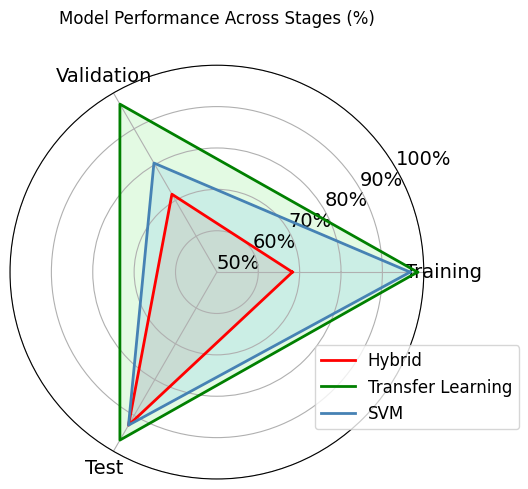

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Model names
model_names = ['Hybrid', 'Transfer Learning', 'SVM']

# Metrics data (in percentages)
data = {
    'Training': [68.25, 98.49, 96.70],
    'Validation': [71.74, 96.88, 80.43],
    'Test': [92.71, 96.88, 92.71]
}

# Custom colors for each model
model_colors = {
    'Hybrid': ('red', 'lightcoral'),
    'Transfer Learning': ('green', 'lightgreen'),
    'SVM': ('steelblue', 'skyblue'),
    'RF': ('purple', 'violet')
}

# Categories and angles
categories = list(data.keys())
N = len(categories)

# Generate evenly spaced angles
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Set up plot
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(polar=True))

# Plot each model
for i, model_name in enumerate(model_names):
    values = [data[c][i] for c in categories]
    values += values[:1]  # Close the loop

    line_color, fill_color = model_colors[model_name]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=line_color)
    ax.fill(angles, values, color=fill_color, alpha=0.25)

# Fix axis labels and formatting
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=14, color='black')
ax.set_rlabel_position(30)

# 🔁 Custom Y-Ticks: Start from 50%
ytick_values = [50, 60, 70, 80, 90, 100]
ytick_labels = ["50%", "60%", "70%", "80%", "90%", "100%"]

plt.yticks(ytick_values, ytick_labels, color="black", size=14)
plt.ylim(50, 100)  # Set y-axis limits from 50 to 100

# Add legend
plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.1), fontsize=12)

# Show plot
plt.title('Model Performance Across Stages (%)', pad=30)
plt.tight_layout()
plt.show()

/tmp/ipython-input-82-1111660350.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=model_names, y=test_accuracy, palette="viridis")


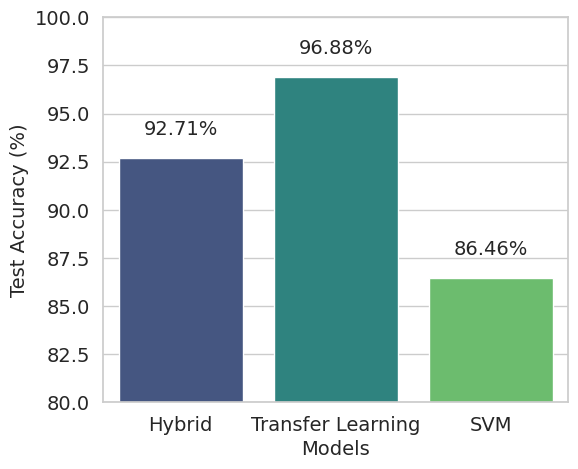

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files # Import the files object

# Model names
model_names = ['Hybrid', 'Transfer Learning', 'SVM']

# Test accuracy values
test_accuracy = [92.71, 96.88, 92.71]

# Set style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(6, 5))
barplot = sns.barplot(x=model_names, y=test_accuracy, palette="viridis")

# Add percentage labels on top of bars
for index, value in enumerate(test_accuracy):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=14)

# Titles and labels

plt.xlabel('Models', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.ylim(80, 100)  # Limit y-axis for better comparison
plt.tick_params(axis='both', which='major', labelsize=14)
# Show plot
plt.savefig('acc_1.png', dpi=600, bbox_inches='tight', facecolor='white')

# Show the plot in notebook
plt.show()

# Download the saved image
#files.download('acc_1.png')

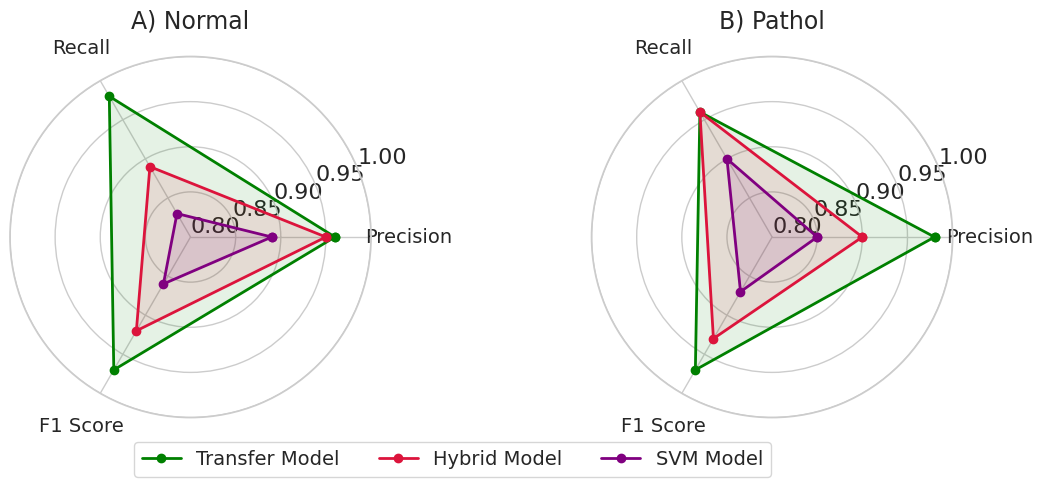

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics for each model
metrics = ['Precision', 'Recall', 'F1 Score']
transfer_model_norm = [0.96  ,  0.98  ,  0.97]  # Precision, Recall, F1 Score
hybrid_model_norm = [0.95  ,  0.89  ,  0.92]
svm_model_norm = [0.89 ,   0.83  ,  0.86 ]  # Example values for SVM


transfer_model_pathol = [0.98,    0.96,    0.97]
hybrid_model_pathol = [0.90,    0.96,    0.93]
svm_model_pathol = [ 0.85 ,   0.90 ,   0.87 ]  # Example values for SVM

# Function to create a radar plot with three models
# Model names and colors
model_names = ['Transfer Model', 'Hybrid Model', 'SVM Model']
model_colors = {
    'Transfer Model': 'green',
    'Hybrid Model': 'crimson',
    'SVM Model': 'purple'
}

# Function to create a radar plot with three models
def create_radar_plot(ax, data_1, data_2, data_3, labels, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Extend data to complete the loop
    data_1 += data_1[:1]
    data_2 += data_2[:1]
    data_3 += data_3[:1]

    # Plot data
    ax.plot(angles, data_1, label='Transfer Model', linewidth=2, linestyle='solid', marker='o', color=model_colors['Transfer Model'])
    ax.fill(angles, data_1, color=model_colors['Transfer Model'], alpha=0.1)

    ax.plot(angles, data_2, label='Hybrid Model', linewidth=2, linestyle='solid', marker='o', color=model_colors['Hybrid Model'])
    ax.fill(angles, data_2, color=model_colors['Hybrid Model'], alpha=0.1)

    ax.plot(angles, data_3, label='SVM Model', linewidth=2, linestyle='solid', marker='o', color=model_colors['SVM Model'])
    ax.fill(angles, data_3, color=model_colors['SVM Model'], alpha=0.1)

    # Axis setup
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=14)
    ax.tick_params(axis='y', labelsize=14,pad=3)

    # Set fewer radial ticks
    ax.set_yticks([0.80, 0.85, 0.90, 0.95, 1.00])
    ax.set_yticklabels(['0.80', '0.85', '0.90', '0.95', '1.00'], fontsize=16)
    ax.set_ylim(0.80, 1.00)

    # Title
    ax.set_title(title, fontsize=17, pad=20)
    ax.tick_params(pad=14)  # Increase label padding

    return ax

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw=dict(polar=True))

# Plot Normal class
create_radar_plot(
    axes[0],
    transfer_model_norm,
    hybrid_model_norm,
    svm_model_norm,
    metrics,
    title="A) Normal"
)

# Plot Pathol class
create_radar_plot(
    axes[1],
    transfer_model_pathol,
    hybrid_model_pathol,
    svm_model_pathol,
    metrics,
    title="B) Pathol"
)

# Create a single legend for all models
handles = [
    plt.Line2D([0], [0], color=model_colors[name], lw=2, linestyle='solid', marker='o')
    for name in model_names
]

fig.legend(handles, model_names, loc='lower center', bbox_to_anchor=(0.45, -0.04), ncol=3, fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space at bottom for legend
plt.savefig('radar_1.png', dpi=600, bbox_inches='tight', facecolor='white')

# Show the plot in notebook
plt.show()

# Download the saved image
#files.download('radar_1.png')
